# XGBoost

Exploring the use of XGBoost and its integration with Scikit-Learn.

Some useful links:
* [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/index.html)
* [Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html)
* [Python package](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)
* [Python examples](https://github.com/dmlc/xgboost/tree/master/demo/guide-python)
* [scikit-learn examples](https://github.com/dmlc/xgboost/blob/master/demo/guide-python/sklearn_examples.py)
* [Diabetes dataset](http://scikit-learn.org/stable/datasets/index.html#diabetes-dataset)
* [Breast cancer dataset](http://scikit-learn.org/stable/datasets/index.html#breast-cancer-wisconsin-diagnostic-database)

Objective is to demonstrate:
* regression ✓
* binary classification ✓
* multiclass classification ✓
* cross-validation ✓
* hyperparameter searching ✓
* feature importance ✓
* early stopping ✓
* evaluations
* plotting ✓

In [9]:
import numpy as np

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [3]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [4]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

## Regression

In [6]:
diabetes = load_diabetes()

X = diabetes.data
y = diabetes.target

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

xgb_model.fit(X, y)

y_pred = xgb_model.predict(X)

mse=mean_squared_error(y, y_pred)

print(np.sqrt(mse))

0.2401475171547707


In [7]:
xgb_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

## Binary classification

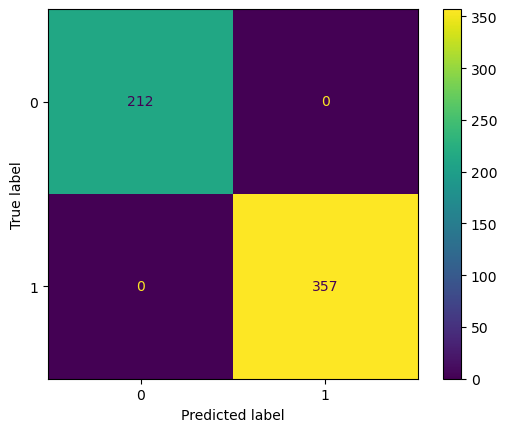

In [10]:
cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X, y)

y_pred = xgb_model.predict(X)

ConfusionMatrixDisplay(confusion_matrix(y, y_pred)).plot()

## Multiclass classification

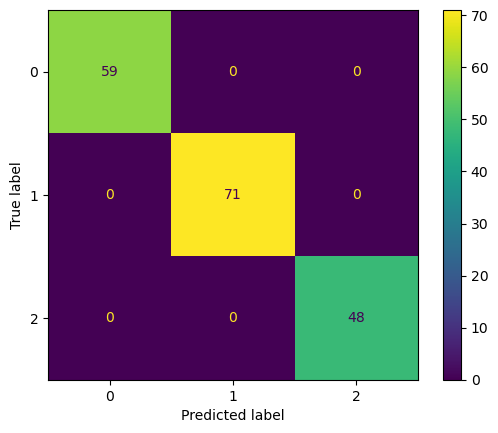

In [11]:
wine = load_wine()

X = wine.data
y = wine.target

xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
xgb_model.fit(X, y)

y_pred = xgb_model.predict(X)

ConfusionMatrixDisplay(confusion_matrix(y, y_pred)).plot()

## Cross validation

Cross-validation using `KFold`

In [13]:
diabetes = load_diabetes()

X = diabetes.data
y = diabetes.target

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores = []

for train_index, test_index in kfold.split(X):   
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb_model = xgb.XGBRegressor(objective="reg:squarederror")
    xgb_model.fit(X_train, y_train)
    
    y_pred = xgb_model.predict(X_test)
    
    scores.append(mean_squared_error(y_test, y_pred))
    
display_scores(np.sqrt(scores))

Scores: [63.93059871 61.44356415 67.49238017 69.51815605 59.9786771 ]
Mean: 64.473
Std: 3.584


Cross-validation using `cross_val_score`

In [14]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

scores = cross_val_score(xgb_model, X, y, scoring="neg_mean_squared_error", cv=5)

display_scores(np.sqrt(-scores))

Scores: [62.80101886 65.78389959 62.21211593 66.40836809 67.3001013 ]
Mean: 64.901
Std: 2.022


## Hyperparameter searching

In [15]:
diabetes = load_diabetes()

X = diabetes.data
y = diabetes.target

xgb_model = xgb.XGBRegressor()

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X, y)

report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Model with rank: 1
Mean validation score: 0.464 (std: 0.012)
Parameters: {'colsample_bytree': 0.7902634929450308, 'gamma': 0.1424202471887338, 'learning_rate': 0.041066084206359835, 'max_depth': 2, 'n_estimators': 101, 'subsample': 0.8010716092915446}



## Early stopping

The number of boosted trees (`n_estimators`) to train is uncapped, rather training continues until validation has not improved in *n* rounds

In [16]:
cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

# if more than one evaluation metric are given the last one is used for early stopping
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

y_pred = xgb_model.predict(X_test)

accuracy_score(y_test, y_pred)

[0]	validation_0-auc:0.96348
[1]	validation_0-auc:0.97201
[2]	validation_0-auc:0.97035
[3]	validation_0-auc:0.97930
[4]	validation_0-auc:0.97857
[5]	validation_0-auc:0.97784
[6]	validation_0-auc:0.98408
[7]	validation_0-auc:0.98450
[8]	validation_0-auc:0.98616
[9]	validation_0-auc:0.99105
[10]	validation_0-auc:0.99126
[11]	validation_0-auc:0.99064
[12]	validation_0-auc:0.99147
[13]	validation_0-auc:0.99209
[14]	validation_0-auc:0.99209
[15]	validation_0-auc:0.99147
[16]	validation_0-auc:0.99168
[17]	validation_0-auc:0.99126
[18]	validation_0-auc:0.99189


c:\Users\bovam\miniconda3\envs\sportsenv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.958041958041958

`xgb_model.fit()` will produce a model from the last iteration, not the best one, so to get the optimum model consider retraining over `xgb_model.best_iteration` rounds.

In [17]:
print("best score: {0}, best iteration: {1}, best ntree limit {2}".format(xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))

best score: 0.992093216812318, best iteration: 13, best ntree limit 14


## Evaluations

In [18]:
cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

xgb_model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=20, random_state=42, eval_metric=["auc", "error", "error@0.6"])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

y_pred = xgb_model.predict(X_test)

[0]	validation_0-auc:0.96348	validation_0-error:0.04895	validation_0-error@0.6:0.07692
[1]	validation_0-auc:0.97201	validation_0-error:0.04895	validation_0-error@0.6:0.06294
[2]	validation_0-auc:0.97035	validation_0-error:0.04196	validation_0-error@0.6:0.05594
[3]	validation_0-auc:0.97930	validation_0-error:0.04196	validation_0-error@0.6:0.06294
[4]	validation_0-auc:0.97857	validation_0-error:0.03497	validation_0-error@0.6:0.04895
[5]	validation_0-auc:0.97784	validation_0-error:0.04196	validation_0-error@0.6:0.04196
[6]	validation_0-auc:0.98408	validation_0-error:0.03497	validation_0-error@0.6:0.04895
[7]	validation_0-auc:0.98450	validation_0-error:0.04895	validation_0-error@0.6:0.04196
[8]	validation_0-auc:0.98616	validation_0-error:0.04895	validation_0-error@0.6:0.04895
[9]	validation_0-auc:0.99105	validation_0-error:0.04895	validation_0-error@0.6:0.04196
[10]	validation_0-auc:0.99126	validation_0-error:0.04895	validation_0-error@0.6:0.04196
[11]	validation_0-auc:0.99064	validation_0

## Plotting

c:\Users\bovam\miniconda3\envs\sportsenv\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


ImportError: You must install graphviz to plot tree

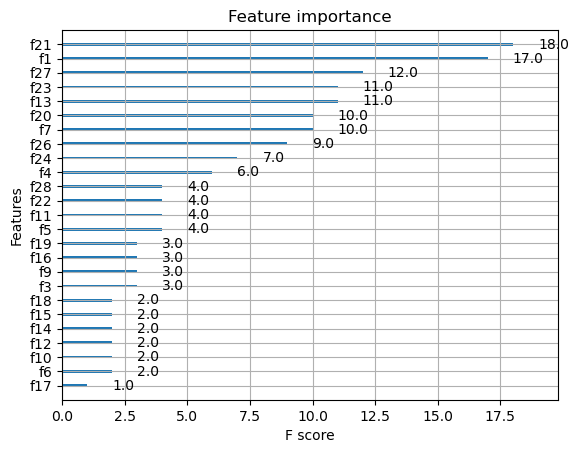

In [20]:
# requires graphviz and python-graphviz conda packages
import graphviz

cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)

xgb.plot_importance(xgb_model)

# plot the output tree via matplotlib, specifying the ordinal number of the target tree
# xgb.plot_tree(xgb_model, num_trees=xgb_model.best_iteration)

# converts the target tree to a graphviz instance
xgb.to_graphviz(xgb_model, num_trees=xgb_model.best_iteration)